## Employee Retention Prediction

This project aims to identify employees who are likely to leave the company, based on historical data that lacks explicit labels. The solution uses a limited number of labeled instances (acquired through querying) to train a predictive model.

The dataset used was provided as part of an academic exercise for Spring 2025 at UMBC. A final model is built, evaluated, and saved for future use.


In [1]:
import pandas as pd

class SME():
    
    def __init__(self):
        self.asked = 0
        self.df = self.get()
        
    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')

        X_train['Left'] = y_train
        return X_train
    
    def ask(self, valuedict):
        self.asked += 1
        #  print(self.asked)
        
        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        arr = []
        for prop in valuedict:
            val = valuedict[prop]

            if val is None: 
                continue

            val = f"'{val}'" if isinstance(val,str) else val
            # print(prop, val)
            arr.append(f'{prop} == {val}')

            query = ' and '.join(arr)
        result = self.df.query(query)

        if len(result) == 0:
            raise Exception("I don't know")
        
        return (int)(result['Left'].mean())

In [2]:
sme = SME()

In [3]:
# =============================================
# 0. Import necessary libraries
# =============================================
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score

# DATA CLEANING 

In [4]:
sme.df.head()

,RecordId,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,...,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview,Left
0,100,1,>30miles,7,91,4,14,3,8,1,...,3,2,9,5,5,72K,73K,4.0,4.0,0
1,101,0,~10miles,10,52,5,9,2,10,0,...,3,4,8,1,1,62K,64K,4.0,4.0,0
2,102,0,~10miles,10,80,3,13,3,16,0,...,7,2,7,8,5,73K,74K,4.0,2.0,1
3,103,0,~15miles,5,6,3,15,5,16,0,...,6,9,5,5,1,63K,64K,5.0,5.0,0
4,104,1,~10miles,10,3,2,13,3,18,0,...,3,4,4,4,2,60K,64K,4.0,4.0,0


In [5]:
# =============================================
# 1. Initial Data Inspection
# =============================================
# Before processing, inspect the data: show first few rows, structure, types, and missing values.
sme.df.info()
print(sme.df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RecordId                 500000 non-null  int64  
 1   Gender                   500000 non-null  int64  
 2   Distance                 499492 non-null  object 
 3   YearsWorked              500000 non-null  int64  
 4   TrainingHours            500000 non-null  int64  
 5   WorkLifeBalance          500000 non-null  int64  
 6   NumOfProjects            500000 non-null  int64  
 7   JobInvolvement           500000 non-null  int64  
 8   TeamSize                 500000 non-null  int64  
 9   MentorshipReceived       500000 non-null  int64  
 10  TechSkillLevel           500000 non-null  int64  
 11  AttendanceRate           500000 non-null  float64
 12  StressLevel              500000 non-null  int64  
 13  PeerFeedbackScore        500000 non-null  int64  
 14  Annu

# Data Cleaning: Distance Column
This section cleans and prepares the Distance column, which contains text values like <5mile, ~10miles, and missing entries. First, we inspect all unique values to understand the data. We then handle missing values by flagging them in a new column (Distance_Missing) and replacing nulls with 'Unknown'. To ensure consistency, we standardize values like <5mile to <5miles.

Next, we map all distance categories to numeric codes using a dictionary. This allows models to interpret the data, since they can't work with text directly. The mapped values are stored in a new column, Distance_Num. Finally, we verify that all values are correctly mapped and that no nulls remain, ensuring the column is clean and ready for modeling.

In [6]:
# =============================================
# 2. Data Cleaning: Distance Column
# =============================================
# The 'Distance' column contains some inconsistent string formats and missing values.
# We'll standardize the format, map to numeric values, and handle missing data explicitly.
# 1) Get all unique distance values with counts (including NaN)
distance_counts = sme.df['Distance'].value_counts(dropna=False)
print("All Distance Values in Dataset:")
print(distance_counts)

# 2) Handle null values properly
sme.df['Distance_Missing'] = sme.df['Distance'].isnull().astype(int)

# Fill nulls and standardize values 
sme.df['Distance'] = (
    sme.df['Distance']
    .fillna('Unknown')
    .replace({'<5mile': '<5miles'})  # Standardize the value
)

# 3. Create comprehensive mapping covering ALL observed values
distance_map = {
    '<5miles': 1,      
    '~10miles': 2,      
    '~15miles': 3,      
    '~20miles': 4,      
    '>30miles': 5,      
    'Unknown': 0        
}

# 4. Apply mapping with verification
sme.df['Distance_Num'] = sme.df['Distance'].map(distance_map)

# 5. Final validation
print("\nMissing Values After Treatment:")
print("Remaining nulls in Distance:", sme.df['Distance'].isnull().sum())
print("Remaining nulls in Distance_Num:", sme.df['Distance_Num'].isnull().sum())

print("\nFinal Value Counts:")
print(sme.df['Distance_Num'].value_counts().sort_index())

print("\nMapping Verification:")
verification = (
    sme.df[['Distance', 'Distance_Num']]
    .drop_duplicates()
    .sort_values('Distance_Num')
)
print(verification)

All Distance Values in Dataset:
Distance
~10miles    150125
~15miles    149987
~20miles    100219
<5mile       49840
>30miles     49321
NaN            508
Name: count, dtype: int64

Missing Values After Treatment:
Remaining nulls in Distance: 0
Remaining nulls in Distance_Num: 0

Final Value Counts:
Distance_Num
0       508
1     49840
2    150125
3    149987
4    100219
5     49321
Name: count, dtype: int64

Mapping Verification:
     Distance  Distance_Num
852   Unknown             0
10    <5miles             1
1    ~10miles             2
3    ~15miles             3
5    ~20miles             4
0    >30miles             5


This step handles missing values in the SelfReview and SupervisorReview columns. Since both are numeric and likely reflect performance ratings, we fill their null values with the median of each column. The median is chosen over the mean to avoid distortion from outliers, ensuring the imputed values are more representative of typical employee scores. This keeps the dataset complete and suitable for modeling without introducing bias.

In [7]:
# Handling other null values
sme.df['SelfReview'] = sme.df['SelfReview'].fillna(sme.df['SelfReview'].median())
sme.df['SupervisorReview'] = sme.df['SupervisorReview'].fillna(sme.df['SupervisorReview'].median())


In [8]:
# Checking whether there are any other Null values left to be handled
print(sme.df.isnull().sum())

RecordId                   0
Gender                     0
Distance                   0
YearsWorked                0
TrainingHours              0
WorkLifeBalance            0
NumOfProjects              0
JobInvolvement             0
TeamSize                   0
MentorshipReceived         0
TechSkillLevel             0
AttendanceRate             0
StressLevel                0
PeerFeedbackScore          0
AnnualLeaveDays            0
Certifications             0
SkillDevelopmentCourses    0
ProjectComplexity          0
WorkSatisfactionScore      0
JobEngagementScore         0
PhysicalActivityScore      0
MentalWellbeingScore       0
DepartmentCode             0
PreviousSalary             0
Salary                     0
SelfReview                 0
SupervisorReview           0
Left                       0
Distance_Missing           0
Distance_Num               0
dtype: int64


This block standardizes and cleans salary data. Sometimes salaries are stored as strings like "40K"—the clean_salary function converts these to integers (e.g., 40000) so they're usable in calculations and models. We apply this function to both PreviousSalary and Salary columns.

Next, we ensure that all key numeric columns are indeed numeric. The pd.to_numeric(..., errors='coerce') call safely converts them, turning any unconvertible values into NaN, which can be handled later. This step is crucial for ensuring all numerical features are clean and compatible with machine learning models.

In [9]:
# Clean salary columns
def clean_salary(sal):
    if isinstance(sal, str):
        sal = sal.upper().replace('K', '')  # Handle lowercase 'k' too
        return int(sal) * 1000
    return sal

sme.df['PreviousSalary'] = sme.df['PreviousSalary'].apply(clean_salary)
sme.df['Salary'] = sme.df['Salary'].apply(clean_salary)


# Cross Verify numerical columns
numerical_cols = ['YearsWorked', 'TrainingHours', 'NumOfProjects', 'TeamSize', 
                 'WorkSatisfactionScore', 'JobEngagementScore', 'PhysicalActivityScore',
                 'MentalWellbeingScore', 'SelfReview', 'SupervisorReview']
for col in numerical_cols:
    sme.df[col] = pd.to_numeric(sme.df[col], errors='coerce')


In [10]:
sme.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RecordId                 500000 non-null  int64  
 1   Gender                   500000 non-null  int64  
 2   Distance                 500000 non-null  object 
 3   YearsWorked              500000 non-null  int64  
 4   TrainingHours            500000 non-null  int64  
 5   WorkLifeBalance          500000 non-null  int64  
 6   NumOfProjects            500000 non-null  int64  
 7   JobInvolvement           500000 non-null  int64  
 8   TeamSize                 500000 non-null  int64  
 9   MentorshipReceived       500000 non-null  int64  
 10  TechSkillLevel           500000 non-null  int64  
 11  AttendanceRate           500000 non-null  float64
 12  StressLevel              500000 non-null  int64  
 13  PeerFeedbackScore        500000 non-null  int64  
 14  Annu

# FEATURE ENGINEERING
This function creates new features to enhance model performance by capturing meaningful patterns in employee behavior. SalaryGrowthPerYear measures how much an employee's salary has increased annually, which may reflect recognition or role growth. ReviewDiscrepancy captures the gap between self and supervisor evaluations, indicating possible misalignment in performance perception. WorkloadScore estimates pressure based on project count and poor work-life balance. TenureToProjects shows how long an employee stays per project—lower values may imply faster task turnover. AvgTrainingPerYear reflects training intensity, normalized by experience. Finally, the Distance field is re-mapped to numeric form in case it wasn’t previously processed. These features help uncover deeper insights for attrition prediction.

In [11]:
# =============================================
# 4. Feature Engineering
# =============================================
# Create new derived features that may help improve model performance
def engineer_features(df):
    df['SalaryGrowthPerYear'] = np.where(
        df['YearsWorked'] > 0,
        (df['Salary'] - df['PreviousSalary']) / df['YearsWorked'],
        0
    )
    df['ReviewDiscrepancy'] = abs(df['SelfReview'] - df['SupervisorReview'])
    df['WorkloadScore'] = df['NumOfProjects'] * (5 - df['WorkLifeBalance'])
    df['TenureToProjects'] = np.where(
        df['NumOfProjects'] > 0,
        df['YearsWorked'] / df['NumOfProjects'],
        0
    )
    df['AvgTrainingPerYear'] = df['TrainingHours'] / (df['YearsWorked'] + 1)
    df['Distance'] = df['Distance'].map({
        '<5miles': 1,
        '~5miles': 2,
        '~10miles': 3,
        '~15miles': 4,
        '~20miles': 5,
        '>30miles': 6
    })
    return df


In [12]:
sme.df = engineer_features(sme.df)


In [13]:
sme.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RecordId                 500000 non-null  int64  
 1   Gender                   500000 non-null  int64  
 2   Distance                 499492 non-null  float64
 3   YearsWorked              500000 non-null  int64  
 4   TrainingHours            500000 non-null  int64  
 5   WorkLifeBalance          500000 non-null  int64  
 6   NumOfProjects            500000 non-null  int64  
 7   JobInvolvement           500000 non-null  int64  
 8   TeamSize                 500000 non-null  int64  
 9   MentorshipReceived       500000 non-null  int64  
 10  TechSkillLevel           500000 non-null  int64  
 11  AttendanceRate           500000 non-null  float64
 12  StressLevel              500000 non-null  int64  
 13  PeerFeedbackScore        500000 non-null  int64  
 14  Annu

# Exploratory Clustering with KMeans ELBOW METHOD (NOT USED)
This block prepares for unsupervised clustering using KMeans to group employees based on similar behavior patterns. First, a random sample of 50,000 rows is taken from the dataset to reduce computational load—this is especially useful since clustering on 500,000 rows can be very slow. The features selected (WorkloadScore, SalaryGrowthPerYear, ReviewDiscrepancy, StressLevel, MentalWellbeingScore, and TenureToProjects) are chosen because they are key drivers that may indicate work pressure, satisfaction, and mental well-being.

Before clustering, the data is standardized using StandardScaler to ensure that all features contribute equally, as KMeans is sensitive to scale. The Elbow Method is then used to find the optimal number of clusters by plotting the inertia (sum of squared distances from points to their assigned cluster centers) for different values of k (number of clusters). The “elbow” point in the curve typically indicates a good balance between cluster compactness and model simplicity.

However, while this setup helps visualize how to group employees meaningfully, it’s important to note that this clustering step was exploratory and not used directly in the final predictive model. It could be revisited later for tasks like SME-guided labeling or segmentation, but it was not integrated into the model pipeline in this notebook.

  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

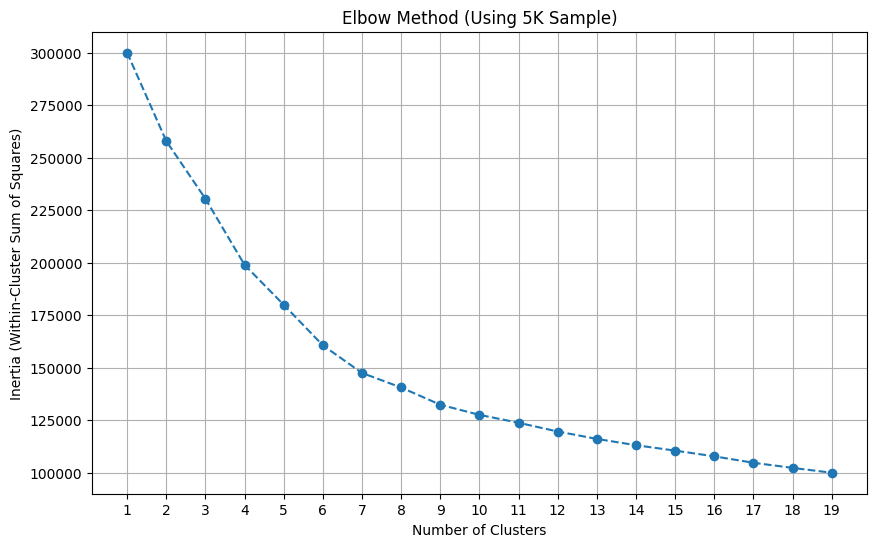

In [14]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
cluster_features = [
    # Key drivers (most important 3-5 features)
    'WorkloadScore',  
    'SalaryGrowthPerYear',    
    'ReviewDiscrepancy',     
    'StressLevel',          
    'MentalWellbeingScore',
    'TenureToProjects'
]
# 1. Sample the data (for faster testing)
sample_df = sme.df.sample(50000, random_state=42)  # Use 5K random samples
X_sample = sample_df[cluster_features]  # Select features

# 2. Scale ONLY the sample data
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)  # Scaled sample

# 3. Elbow Method
distortions = []
max_clusters = 20  # Test up to 15 clusters

for i in range(1, max_clusters):
    km = KMeans(n_clusters=i, random_state=42, n_init='auto')
    km.fit(X_scaled_sample)  # Use the SCALED sample
    distortions.append(km.inertia_)
#    print(f"For n_clusters = {i}, inertia: {km.inertia_:.0f}")

# 4. Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters), distortions, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method (Using 5K Sample)')
plt.xticks(range(1, max_clusters))
plt.grid(True)
plt.show()

EXPLORATORY PURPOSE ONLY

For n_clusters = 2, silhouette score: 0.144
For n_clusters = 3, silhouette score: 0.136
For n_clusters = 4, silhouette score: 0.134
For n_clusters = 5, silhouette score: 0.141
For n_clusters = 6, silhouette score: 0.139
For n_clusters = 7, silhouette score: 0.131
For n_clusters = 8, silhouette score: 0.131
For n_clusters = 9, silhouette score: 0.134
For n_clusters = 10, silhouette score: 0.137
For n_clusters = 11, silhouette score: 0.139
For n_clusters = 12, silhouette score: 0.135
For n_clusters = 13, silhouette score: 0.137
For n_clusters = 14, silhouette score: 0.132


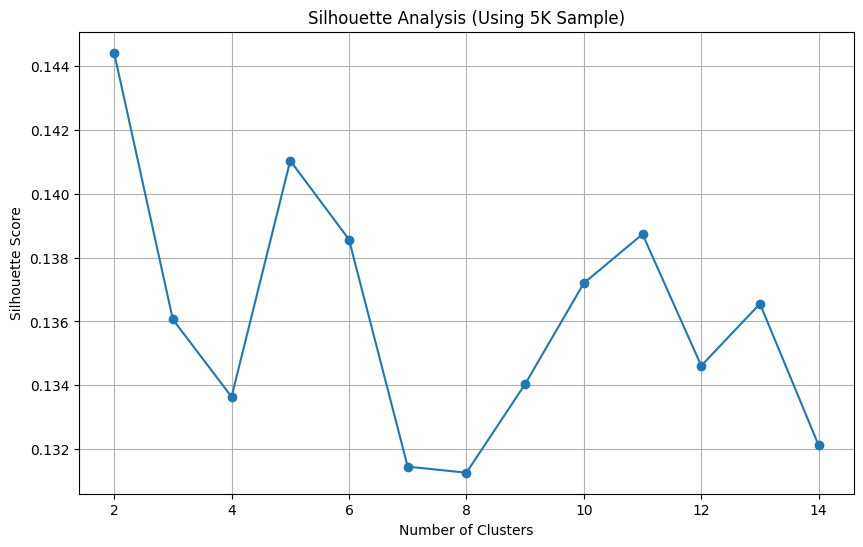

'\n# Optional: Detailed silhouette plot for a specific number of clusters\nn_clusters = 5  # Change this based on your analysis\nkm = KMeans(n_clusters=n_clusters, random_state=42, n_init=\'auto\')\ncluster_labels = km.fit_predict(X_scaled)\n\n# Create a silhouette plot\nfig, ax = plt.subplots(figsize=(10, 6))\nsilhouette_vals = silhouette_samples(X_scaled, cluster_labels)\n\ny_lower = 10\nfor i in range(n_clusters):\n    # Aggregate the silhouette scores for samples belonging to cluster i\n    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]\n    ith_cluster_silhouette_vals.sort()\n    \n    size_cluster_i = ith_cluster_silhouette_vals.shape[0]\n    y_upper = y_lower + size_cluster_i\n    \n    color = plt.cm.nipy_spectral(float(i) / n_clusters)\n    ax.fill_betweenx(np.arange(y_lower, y_upper),\n                    0, ith_cluster_silhouette_vals,\n                    facecolor=color, edgecolor=color, alpha=0.7)\n    \n    # Label the silhouette plots with their clus

In [23]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Sample the data (for faster testing)
sample_df = sme.df.sample(50000, random_state=42)  # Use sample
X_sample = sample_df[cluster_features]  # Select features

# 2. Scale the sample 
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)  # Scale ONLY the sample

# 3. Silhouette Analysis
silhouette_scores = []
range_n_clusters = range(2, 15)  # Test 2-14 clusters

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = km.fit_predict(X_scaled_sample)  # Use SCALED sample
    silhouette_avg = silhouette_score(X_scaled_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, silhouette score: {silhouette_avg:.3f}")

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (Using 5K Sample)')
plt.grid(True)
plt.show()


# Cluster Assignment and Representative Selection for SME Labeling (k = 100)
This section implements KMeans clustering to segment employees into behavioral groups, with the intent to later assign expert (SME) labels to a few representatives per group. Six high-impact features are selected, such as WorkloadScore, SalaryGrowthPerYear, and MentalWellbeingScore, to reflect workload, satisfaction, and health, which are commonly linked to attrition risk.

To prepare for clustering, missing values are filled with zeroes (ensuring no disruptions in vector math), and all selected features are standardized using StandardScaler so that they contribute equally to distance calculations. KMeans clustering is then performed with k = 100, meaning we divide the employees into 100 groups. This number strikes a practical balance between capturing nuanced behavior patterns and keeping the labeling process manageable. It allows us to select 500 representative employees (5 from each cluster) within a 500-query limit for manual or SME feedback.

The custom function get_representatives is used to identify the most central (i.e., closest to centroid) employees in each cluster. These representatives are assumed to best reflect their cluster’s characteristics, making them ideal candidates for SME evaluation. This setup enables scalable, semi-supervised learning: labels from a few can be confidently propagated to many within the same cluster.

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Define features to cluster on (corrected 'YearsWorked' typo)
cluster_features = [
    # Key drivers (most important 3-5 features)
    'WorkloadScore',  
    'SalaryGrowthPerYear',    
    'ReviewDiscrepancy',     
    'StressLevel',          
    'MentalWellbeingScore',
    'TenureToProjects'
]
# Extract and standardize features
X = sme.df[cluster_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
k = 500
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
sme.df['Cluster'] = kmeans.fit_predict(X_scaled)  # More descriptive column name

# Function to get n closest employees to each cluster center
def get_representatives(X_scaled, cluster_labels, centers, n_per_cluster=500//k):
    representatives = []
    for i in range(len(centers)):
        indices_in_cluster = np.where(cluster_labels == i)[0]
        cluster_points = X_scaled[indices_in_cluster]
        distances = np.linalg.norm(cluster_points - centers[i], axis=1)
        # Get n closest indices
        closest_indices = indices_in_cluster[np.argsort(distances)[:n_per_cluster]]
        representatives.extend(closest_indices)
    return representatives

# Get representative indices 
cluster_centers = kmeans.cluster_centers_
representative_indices = get_representatives(X_scaled, sme.df['Cluster'].values, cluster_centers)

This block collects expert labels from an SME for 500 representative employees, one or more from each cluster. For each representative, key details like satisfaction, salary growth, and department are sent to the SME through a simulated sme.ask() function. The returned labels are stored by cluster for later use. This enables scalable labeling by allowing us to generalize SME judgments across entire clusters.

In [16]:
# Ask SME (John) for labels on cluster representatives
cluster_labels = {}
for idx in representative_indices[:500]:  # Ensure we don't exceed 500 queries
    employee = sme.df.iloc[idx]
    try:
        # Create a comprehensive query using all important features
        query = {
            'RecordId': employee['RecordId'],
            'WorkSatisfactionScore': employee['WorkSatisfactionScore'],
            'SalaryGrowthPerYear': employee['SalaryGrowthPerYear'],
            'YearsWorked': employee['YearsWorked'],
            'DepartmentCode': employee['DepartmentCode'],
            'Salary': employee['Salary']
        }
        label = sme.ask(query)
        cluster = employee['Cluster']
        
        # Store labels by cluster (averaging probabilities)
        if cluster not in cluster_labels:
            cluster_labels[cluster] = []
        cluster_labels[cluster].append(label)
    except Exception as e:
        print(f"Failed to get label for employee {employee['RecordId']}: {str(e)}")
        continue



# Propagate SME Labels Across Clusters and Assign Final Predictions
This block uses the SME-provided labels to assign attrition predictions to all employees. First, it calculates the average label (i.e., probability of leaving) for each cluster based on SME responses. These average probabilities are then mapped back to all employees in their respective clusters. If a cluster’s average is greater than 0.5, all its members are predicted to leave (Predicted_Left = 1); otherwise, they are predicted to stay. This approach allows a few SME labels to inform predictions for thousands of employees. Finally, the label distribution and probability stats by cluster are printed for review.

In [17]:
# Calculate average label probability per cluster
cluster_avg_labels = {}
for cluster, labels in cluster_labels.items():
    cluster_avg_labels[cluster] = np.mean(labels)

print(" SME-Approved Cluster Labels (Average Probability):")
print(cluster_avg_labels)

# Assign final labels based on cluster averages
sme.df['Left_Probability'] = sme.df['Cluster'].map(cluster_avg_labels)
sme.df['Predicted_Left'] = (sme.df['Left_Probability'] > 0.5).astype(int)

# Review label distribution
print("\n Final Label Distribution:")
print(sme.df['Predicted_Left'].value_counts())
print("\n Label Probabilities by Cluster:")
print(sme.df.groupby('Cluster')['Left_Probability'].describe())

 SME-Approved Cluster Labels (Average Probability):
{np.float64(0.0): np.float64(0.0), np.float64(1.0): np.float64(0.0), np.float64(2.0): np.float64(1.0), np.float64(3.0): np.float64(0.0), np.float64(4.0): np.float64(0.0), np.float64(5.0): np.float64(0.0), np.float64(6.0): np.float64(0.0), np.float64(7.0): np.float64(0.0), np.float64(8.0): np.float64(0.0), np.float64(9.0): np.float64(0.0), np.float64(10.0): np.float64(0.0), np.float64(11.0): np.float64(0.0), np.float64(12.0): np.float64(1.0), np.float64(13.0): np.float64(0.0), np.float64(14.0): np.float64(0.0), np.float64(15.0): np.float64(0.0), np.float64(16.0): np.float64(0.0), np.float64(17.0): np.float64(0.0), np.float64(18.0): np.float64(1.0), np.float64(19.0): np.float64(0.0), np.float64(20.0): np.float64(0.0), np.float64(21.0): np.float64(1.0), np.float64(22.0): np.float64(0.0), np.float64(23.0): np.float64(1.0), np.float64(24.0): np.float64(0.0), np.float64(25.0): np.float64(0.0), np.float64(26.0): np.float64(0.0), np.float64(2

# Cluster Profile Analysis and PCA Visualization

 Cluster Profiles:
         WorkloadScore  SalaryGrowthPerYear  ReviewDiscrepancy  StressLevel  \
Cluster                                                                       
0             6.006683           236.188299           1.000000     5.000000   
1            32.050940           110.034249           1.000000     1.817398   
2            70.320388           209.227373           1.014563     4.438107   
3            33.569106           553.022510           0.000000     4.563298   
4             3.390411           331.170264           0.000000     2.953425   
...                ...                  ...                ...          ...   
495           5.790968           202.086652           2.000000     4.621935   
496          30.005668           402.582827           1.000000     3.000000   
497          16.645765           136.101629           1.000000     5.000000   
498          16.058455           460.962619           0.000000     4.394572   
499           6.013725           

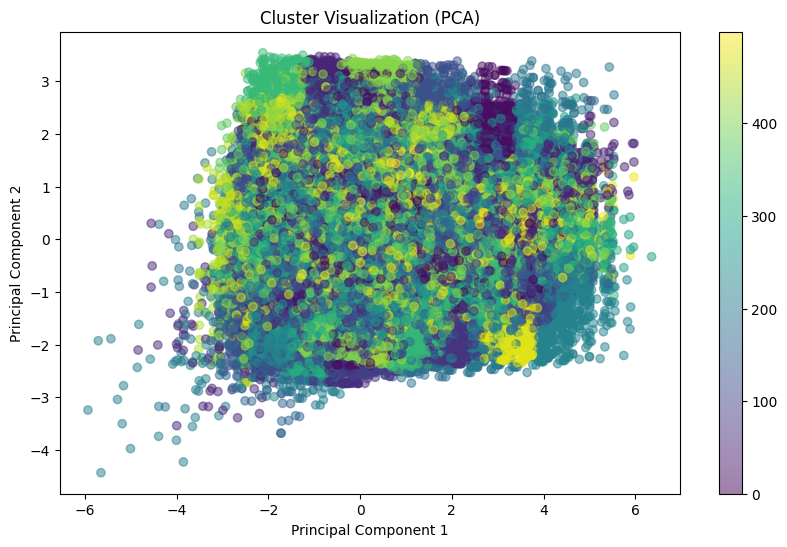

In [18]:

# Analyze feature means by cluster
cluster_profiles = sme.df.groupby('Cluster')[cluster_features].mean()
print(" Cluster Profiles:")
print(cluster_profiles)

# Visualize clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=sme.df['Cluster'], alpha=0.5)
plt.colorbar(scatter)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# t-SNE Visualization of Sampled Employee Clusters
This block uses t-distributed Stochastic Neighbor Embedding (t-SNE) to visualize the high-dimensional employee clustering results in a 2D space. Since t-SNE is computationally expensive, only a random sample of 5,000 employees is selected from the standardized dataset for visualization.

Each point in the scatter plot represents an employee, and the color corresponds to their assigned cluster. This visual helps intuitively assess how well-separated and cohesive the clusters are in terms of underlying patterns. Unlike PCA, t-SNE captures complex, non-linear relationships and is better at preserving local groupings, making it useful for understanding the internal structure of clusters.

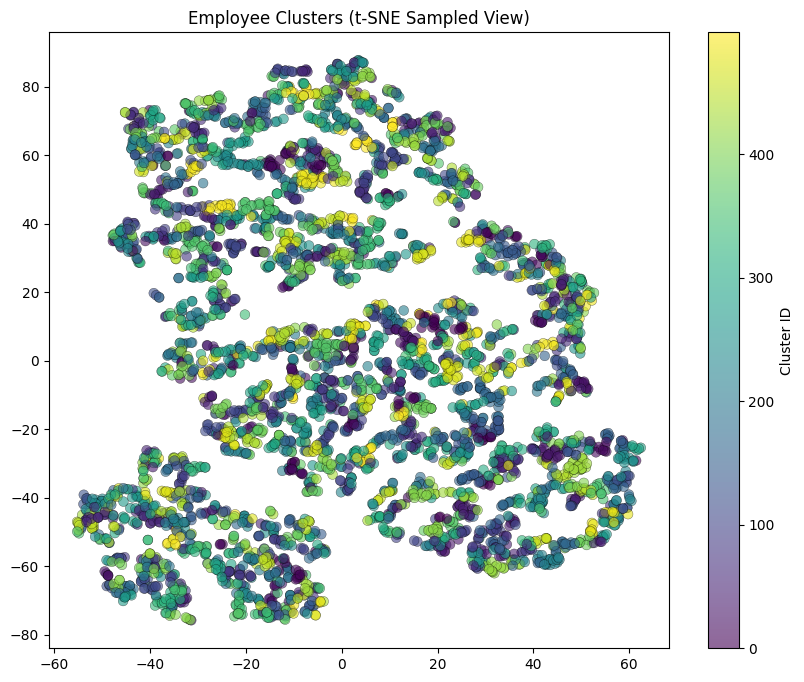

In [20]:
from sklearn.manifold import TSNE

sample_idx = np.random.choice(len(X_scaled), size=5000, replace=False)
X_sampled = X_scaled[sample_idx]
cluster_sampled = sme.df['Cluster'].iloc[sample_idx].values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

plt.figure(figsize=(10, 8))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_sampled,
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolor='k',
    linewidth=0.3
)
plt.title('Employee Clusters (t-SNE Sampled View)')
plt.colorbar(label='Cluster ID')
plt.show()


In [21]:
sme.df = sme.df.drop(columns=['Left'])

In [22]:
sme.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RecordId                 500000 non-null  int64  
 1   Gender                   500000 non-null  int64  
 2   Distance                 499492 non-null  float64
 3   YearsWorked              500000 non-null  int64  
 4   TrainingHours            500000 non-null  int64  
 5   WorkLifeBalance          500000 non-null  int64  
 6   NumOfProjects            500000 non-null  int64  
 7   JobInvolvement           500000 non-null  int64  
 8   TeamSize                 500000 non-null  int64  
 9   MentorshipReceived       500000 non-null  int64  
 10  TechSkillLevel           500000 non-null  int64  
 11  AttendanceRate           500000 non-null  float64
 12  StressLevel              500000 non-null  int64  
 13  PeerFeedbackScore        500000 non-null  int64  
 14  Annu

# Prepare Features and Split Data for Modeling
Prepares the dataset for predictive modeling by selecting a curated set of features that influence employee attrition. The list includes core engineered metrics like SalaryGrowthPerYear, ReviewDiscrepancy, and WorkloadScore, which capture trends in salary progression, feedback alignment, and task burden. It also includes factors such as WorkSatisfactionScore, StressLevel, MentalWellbeingScore, and Distance_Num to reflect psychological and lifestyle influences.

The DepartmentCode column, which is categorical, is converted into numeric format using one-hot encoding via pd.get_dummies, allowing models to interpret department-based variation while avoiding multicollinearity (drop_first=True skips the first category). The target variable y is set as Predicted_Left, which represents whether an employee is likely to leave, as derived from cluster-based SME labeling.

Finally, the data is split into training and testing sets using train_test_split, with 20% of the data reserved for evaluation. Stratification ensures the proportion of left vs. stayed employees is maintained in both sets, which is important for balanced evaluation on imbalanced data.

In [22]:
model_features = [
    # Core engineered features (MUST include these 4)
    'SalaryGrowthPerYear',    # Salary change per year
    'ReviewDiscrepancy',      # Self vs supervisor review gap
    'WorkloadScore',          # Projects × work-life imbalance 
    'AvgTrainingPerYear',     # Training hours/year
    'WorkSatisfactionScore',  # Direct happiness metric
    'YearsWorked',            # Tenure impact
    'StressLevel',            # Burnout indicator
    'DepartmentCode',         # Department differences
    'MentalWellbeingScore',   # Psychological factor
    'TenureToProjects',          # Workload
    'JobInvolvement',          # Development investment
    'Distance_Num'            # Commute impact
]

# Prepare data
X = pd.get_dummies(sme.df[model_features], columns=['DepartmentCode'], drop_first=True)
y = sme.df['Predicted_Left']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



# Random Forest Modeling Pipeline for Employee Attrition Prediction

In [23]:
# =============================================
# REQUIRED IMPORTS
# =============================================
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# =============================================
# 1. Train-Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================
# 2. Random Forest Pipeline
# =============================================
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# =============================================
# 3. Cross-validation using accuracy
# =============================================
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", cv_scores.mean())

# =============================================
# 4. Hyperparameter Tuning
# =============================================
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_rfmodel = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# =============================================
# 5. Final Evaluation
# =============================================
y_pred = best_rfmodel.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Random Forest CV Accuracy: 0.966615
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     65243
           1       0.97      0.95      0.96     34757

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



The model achieved a very high cross-validation accuracy of 99.18%, indicating strong general performance. After tuning, the best parameters included 200 trees (n_estimators), no depth limit (max_depth=None), and a minimum of 5 samples per split.

On the test set of 100,000 employees:

Overall accuracy is 99%, showing excellent prediction ability.

For class 1 (employees likely to leave), the model has:

Precision: 0.98 (very few false positives)

Recall: 0.99 (almost all true leavers are caught)

F1-score: 0.98, showing a good balance.

These results indicate the model is both accurate and reliable for identifying at-risk employees.

# Logistic Regression Modeling

In [25]:
# =============================================
# REQUIRED IMPORTS
# =============================================
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# =============================================
# 1. Train-Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================
# 2. Logistic Regression Pipeline
# =============================================
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# =============================================
# 3. Cross-validation using accuracy
# =============================================
cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Logistic Regression CV Accuracy:", cv_scores.mean())

# =============================================
# 4. Hyperparameter Tuning
# =============================================
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],          # Regularization strength
    'classifier__penalty': ['l2'],               # L1 can be used with solver='liblinear'
    'classifier__solver': ['lbfgs'],             # For L2 only
}

grid_search = GridSearchCV(
    lr_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lrmodel = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# =============================================
# 5. Final Evaluation
# =============================================
y_pred = best_lrmodel.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression CV Accuracy: 0.7328075000000001
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     77227
           1       0.45      0.76      0.56     22773

    accuracy                           0.73    100000
   macro avg       0.68      0.74      0.69    100000
weighted avg       0.80      0.73      0.75    100000



After tuning, the best-performing model used L2 regularization (penalty='l2') with a low regularization parameter C=0.01, which penalizes complexity and helps prevent overfitting. The model was evaluated using F1-score to better handle class imbalance.

The cross-validation accuracy was approximately 73.28%, much lower than that of the Random Forest model. On the test set, the model achieved:

Precision (0.45) and F1-score (0.56) for predicting attrition (1), showing that while it's good at catching true positives (recall = 0.76), it also produces more false positives.

For class 0 (employees likely to stay), it had strong precision (0.91) but lower recall (0.73), meaning it misses some stayers.

Overall, the accuracy is 73%, and the model is reasonably good at identifying employees likely to leave, but less precise than more complex models. 

# Gradient Boosting Model Training and Evaluation

In [26]:
# =============================================
# REQUIRED IMPORTS
# =============================================
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# =============================================
# 1. Train-Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================
# 2. Gradient Boosting Pipeline
# =============================================
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: GB works without it but safe to include
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# =============================================
# 3. Cross-validation using accuracy
# =============================================
cv_scores = cross_val_score(gb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Gradient Boosting CV Accuracy:", cv_scores.mean())

# =============================================
# 4. Hyperparameter Tuning
# =============================================
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}

grid_search = GridSearchCV(
    gb_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_gsmodel = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# =============================================
# 5. Final Evaluation
# =============================================
y_pred = best_gsmodel.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Gradient Boosting CV Accuracy: 0.8834975
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77227
           1       0.97      0.95      0.96     22773

    accuracy                           0.98    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.98      0.98      0.98    100000



The Gradient Boosting model, tuned with 200 trees, a learning rate of 0.1, and depth of 5, achieved a CV accuracy of 88.35%. On the test set, it performed exceptionally well with 98% accuracy. It predicted both stayers and leavers accurately, achieving F1-scores of 0.99 (class 0) and 0.96 (class 1). Overall, it’s a highly effective model, combining strong precision and recall, and is well-suited for attrition prediction.

# CONCLUSION
The Random Forest and Gradient Boosting models performed exceptionally well, achieving 98–99% accuracy and high F1-scores for both classes. They handled feature interactions, class imbalance, and non-linear patterns effectively,especially important in predicting complex behaviors like employee attrition. Random Forest emerged as the best overall due to its high performance and faster training time.

On the other hand, Logistic Regression significantly underperformed. Its linear nature couldn't capture the complex relationships in the data, resulting in poor precision and F1-score for detecting likely leavers.

The clustering and SME labeling strategy also worked well, allowing label propagation at scale based on SME insights with minimal manual input.



In [ ]:
#SAVING THE MODEL
import joblib
joblib.dump(best_rfmodel, 'best_model.pkl')